#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.03011442, -0.64809834,  0.76096101],
       [-0.40317135,  0.6887528 ,  0.60255493],
       [-0.91462888, -0.32494327, -0.24055329]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001865


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000396


In [37]:
C1(dx,dy,dz,Ret)

array([[ 2.56914704e-02,  9.58902131e-01,  4.46882338e-01,
         1.33097416e+00,  1.73806489e-01,  3.17489285e-02,
        -6.42187471e-01, -2.07606085e-02,  1.54516985e+00,
        -1.15158080e+00,  3.26619317e-04, -2.28747904e-01,
         2.02556422e-01, -5.31475756e-02,  2.56217401e-02,
        -6.50481650e-02,  3.25703426e+00, -4.71605603e-01,
        -2.05367194e-01, -5.16612433e-03, -2.57026734e+00,
         4.45308254e-02,  1.13776478e-01,  2.06917990e+00,
         8.64070870e-01,  4.76264166e-01, -5.61583532e-01,
         5.75085886e-01,  1.90028881e-02, -1.21346751e-03,
        -2.07351600e-01,  7.85606124e+00, -4.57315263e-01,
         9.90315738e-05,  3.13541256e-05, -8.73057966e-01,
         7.04610927e-01, -2.06387582e-01,  1.07619874e+00,
        -7.65097226e-01,  7.09893208e-01,  9.54465432e-01,
        -6.14688833e-01,  1.01119122e-01,  1.10431488e+00,
         3.19874586e-01,  1.62105186e+00, -1.96081788e+00,
        -7.55271333e-01, -1.25139834e+00],
       [ 3.63

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.47444221e+02,  2.08393770e+03,  1.24296529e+03],
       [ 5.50317187e+03, -1.84836909e+04, -1.88565610e+04],
       [ 2.56467291e+03,  3.21905763e+03,  9.42240188e+03],
       [ 7.63850587e+03, -1.87340452e+03, -1.16016356e+03],
       [ 9.97481341e+02, -2.82195460e+03,  1.11331421e+03],
       [ 1.82208178e+02, -8.97091432e+03, -3.67508030e+03],
       [-3.68553569e+03, -1.20992142e+04,  1.37766059e+03],
       [-1.19145837e+02,  7.18211170e+03,  3.85288181e+03],
       [ 8.86778221e+03,  1.79150959e+04,  2.48108484e+03],
       [-6.60896128e+03, -3.77047227e+03,  1.27261290e+03],
       [ 1.87447935e+00, -3.47443107e+03,  1.02785876e+03],
       [-1.31279198e+03, -2.79900286e+03, -2.93636523e+03],
       [ 1.16247818e+03,  5.69444500e+02,  5.78928820e+02],
       [-3.05015740e+02, -5.72366274e+02, -1.42684734e+04],
       [ 1.47044036e+02,  4.08784026e+03, -8.66680252e+01],
       [-3.73313626e+02,  3.88855212e+02, -3.52731486e+02],
       [ 1.86922302e+04,  8.41955433e+02

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000248


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.008800


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000026


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 1.88929014e+00, -6.56108320e-01, -1.31786545e+00],
       [ 2.15513199e+00, -6.43074294e-01,  1.20967764e+00],
       [ 2.34521080e+00, -4.97405897e-01, -9.42258596e-01],
       [-5.27069749e-01, -1.94283628e-01, -6.40671859e-01],
       [-5.64471500e-02,  9.30876862e-01, -1.58338986e+00],
       [-2.77125697e+00, -1.14079813e+00, -9.92556504e-02],
       [-3.39992015e-01,  7.52842959e-01,  7.47293147e-01],
       [-5.28111948e-01,  2.30392086e-01, -1.13829901e+00],
       [ 2.68562745e-01,  1.06841935e+00, -1.01460132e+00],
       [-1.59792636e+00, -7.07165723e-01,  1.36700787e+00],
       [-5.51496190e-01,  1.56591429e-01, -8.28347782e-01],
       [-1.47477287e+00, -8.17065291e-02,  1.61345590e+00],
       [-2.91186962e-01,  1.94101026e-02,  6.69080006e-01],
       [-5.36896434e-01, -5.94166478e-01, -6.66518646e-01],
       [-1.44902762e+00, -1.52298173e+00,  9.29421290e-01],
       [-1.43503061e+00, -1.68860969e+00,  8.32263743e-01],
       [-1.03590109e+00, -1.08607271e+00

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000086


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000492


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000536


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 7.72281165e-01,  1.44472522e-01,  1.36303132e+00],
       [-2.08070900e-01,  1.55786752e+00,  7.44016691e-01],
       [-9.78693962e-03, -2.72036049e-01, -2.15105794e-01],
       [ 1.60474071e+00, -5.28212232e-01, -5.07228796e-01],
       [-2.16586497e-01, -1.74186293e+00,  1.47832372e+00],
       [ 1.34602468e+00, -7.31346828e-01,  1.09312146e+00],
       [ 2.58541383e-01,  6.48381449e-01,  3.81268929e-01],
       [ 4.71406855e-01, -1.25890867e+00,  1.88477680e+00],
       [-1.23722060e+00, -8.09852210e-01, -3.70270887e-01],
       [ 1.76958634e+00,  8.93565022e-01,  9.19767003e-01],
       [-9.81012866e-01,  4.43902648e-02, -5.06869196e-02],
       [ 3.00255884e-02, -8.72260248e-01, -9.59417274e-01],
       [ 1.43661008e+00,  3.19253636e+00,  1.02156149e+00],
       [ 9.33959845e-01, -3.21128680e+00,  2.44084746e-01],
       [ 5.41379841e-01,  6.74532494e-01, -8.59996050e-01],
       [-6.21245876e-01,  9.87149647e-01,  1.24633557e+00],
       [-6.16009008e-01, -1.34233084e+00

In [63]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-5.99110305e-03,  1.66443464e-02, -4.03033268e-03,
        -4.02836084e-03, -2.25840855e-02,  9.31617608e-03,
        -1.07306672e-05, -1.23084953e-02, -1.86949860e-02,
         1.86341707e-02, -8.85793445e-03,  1.52550284e-02,
         5.84912273e-03, -6.82249090e-04,  2.19963575e-02,
         2.26040752e-02,  1.86638968e-02,  8.67759552e-04,
         3.92068907e-03, -9.73272171e-03,  1.11039914e-02,
         2.05596846e-02,  1.04902142e-02, -2.37291508e-02,
         5.59157558e-03,  3.77035642e-03, -7.82072709e-03,
         3.65831410e-03,  3.13578253e-04, -1.49596835e-03,
         1.80931580e-02,  1.84813517e-02,  1.19470949e-02,
         8.57647310e-03, -9.90111705e-03, -1.19798642e-02,
        -1.36534222e-02,  1.27390933e-02,  3.82769563e-03,
         8.90573327e-03, -6.39170105e-03,  7.24030713e-03,
        -7.91345255e-03, -1.09496464e-02, -2.49365512e-02,
        -3.07477280e-02,  3.41225336e-03, -7.16842149e-03,
        -3.73153499e-03,  2.31475400e-03],
       [ 1.48

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001192


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.90428130e-06, -9.47304519e-07,  2.89961352e-06,
        -1.24196422e-06, -7.10462588e-07, -1.09549500e-06,
         2.58224436e-07, -2.39706204e-07, -1.38570558e-06,
         2.44142783e-06,  3.03072646e-07, -8.71758109e-07,
        -7.11274520e-07,  9.01098392e-07, -1.72477267e-06,
         2.95850598e-06,  8.67291249e-07,  1.02013562e-06,
         7.45430071e-07, -1.70131192e-06,  5.47057810e-08,
         1.96965344e-07, -3.94793084e-07,  2.84880140e-06,
        -8.97361899e-07, -1.81398390e-07, -1.31347376e-06,
         2.11750878e-06,  1.71086975e-07,  1.14344220e-07,
         1.91556607e-06, -3.03455307e-06,  1.78432585e-06,
         9.95807682e-07, -3.96312145e-07, -9.58534959e-07,
         1.90759945e-06,  2.05937160e-06,  2.75715156e-07,
        -8.37461394e-07,  8.61335483e-07,  4.90484808e-07,
         1.69835268e-07, -5.04367190e-07,  2.06442800e-06,
        -2.33274775e-06,  1.70633408e-06, -9.62737841e-07,
         1.99440225e-07,  4.26470507e-07],
       [-3.90

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.47444221e+02, -5.50317187e+03, -2.56467291e+03,
        -7.63850587e+03, -9.97481341e+02, -1.82208178e+02,
         3.68553569e+03,  1.19145837e+02, -8.86778221e+03,
         6.60896128e+03, -1.87447935e+00,  1.31279198e+03,
        -1.16247818e+03,  3.05015740e+02, -1.47044036e+02,
         3.73313626e+02, -1.86922302e+04,  2.70656056e+03,
         1.17860929e+03,  2.96485628e+01,  1.47508515e+04,
        -2.55563918e+02, -6.52967067e+02, -1.18750937e+04,
        -4.95893205e+03, -2.73329621e+03,  3.22294695e+03,
        -3.30043742e+03, -1.09058220e+02,  6.96413121e+00,
         1.18999787e+03, -4.50862021e+04,  2.62454781e+03,
        -5.68345563e-01, -1.79942391e-01,  5.01050929e+03,
        -4.04378603e+03,  1.18446534e+03, -6.17634112e+03,
         4.39091895e+03, -4.07410121e+03, -5.47770951e+03,
         3.52772007e+03, -5.80326072e+02, -6.33770057e+03,
        -1.83577111e+03, -9.30327163e+03,  1.12532004e+04,
         4.33452781e+03,  7.18181754e+03],
       [-2.08

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001293


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-1.32362745e+02,  1.33775979e+06, -7.62625627e+02],
       [-1.31626625e+02, -5.25535676e+05,  1.85519133e+06],
       [-4.48702504e+02,  2.49513034e+06,  2.03732067e+06],
       [ 3.56246060e+01, -6.01575708e+05,  2.41743514e+05],
       [-1.96861806e-01,  1.18623189e+03,  8.02311519e+02],
       [-6.74225079e+01, -1.34920316e+05,  8.15996984e+05],
       [ 7.08721208e+02, -3.53582889e+06, -3.62315358e+06],
       [-6.63007387e+00,  8.05021662e+04, -1.35324201e+04],
       [ 2.76093619e+01,  1.32607701e+04, -2.92157971e+05],
       [ 5.85159111e+01,  9.86351442e+05, -1.57750109e+06],
       [ 8.86491348e+01, -1.68736864e+05, -7.26745619e+05],
       [-5.70381654e+02,  3.69502318e+06,  2.06651142e+06],
       [ 9.72962305e+01,  3.86135543e+04, -1.02145536e+06],
       [-8.62541419e+01, -5.51010123e+05,  1.42233601e+06],
       [ 2.06454313e+02, -3.42013941e+06,  1.33481030e+06],
       [ 3.68083525e+02, -3.71646935e+06, -1.54551114e+03],
       [-3.34863628e+01,  2.63976055e+05

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.95403457e+05, -7.62819076e+04, -1.33775998e+08],
       [-2.73084612e+04,  1.85519130e+08,  5.25535649e+07],
       [-8.38353411e+08,  2.03649070e+08, -2.49596027e+08],
       [-7.00513148e+06,  2.41736578e+07,  6.01568773e+07],
       [ 4.93317029e+06,  8.07195359e+04, -1.18134830e+05],
       [-2.51206698e+08,  8.15748289e+07,  1.34671634e+07],
       [-3.63607976e+08, -3.62351355e+08,  3.53546894e+08],
       [-2.88757721e+07, -1.35610071e+06, -8.05307518e+06],
       [-1.17749394e+08, -2.92274543e+07, -1.33773361e+06],
       [ 2.95521307e+06, -1.57749816e+08, -9.86348517e+07],
       [-8.84359132e+08, -7.27621134e+07,  1.67861392e+07],
       [-4.78871331e+07,  2.06646401e+08, -3.69507058e+08],
       [ 2.38637845e+08, -1.02121910e+08, -3.83773147e+06],
       [ 5.23615343e+08,  1.42285439e+08,  5.51528476e+07],
       [-1.24714745e+08,  1.33468683e+08,  3.42001595e+08],
       [ 1.53470986e+01, -1.54551112e+05,  3.71646935e+08],
       [-1.11938779e+07,  7.42626588e+06

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000224


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001033


In [82]:
d_me_

array([[ 8.02518070e-02, -8.07368325e+02, -3.25601618e+00],
       [-4.08205340e-02, -5.63865680e+01,  4.68738878e+02],
       [-2.31231790e-03, -4.11196704e+01,  6.44796803e+01],
       [ 1.75617466e-02, -1.66542964e+02, -1.08489355e+01],
       [-5.63027518e-04,  2.85682735e+01, -2.28822873e+01],
       [-4.44919758e-03,  3.30607362e+02, -2.85680456e+02],
       [-1.55305220e-02, -1.33081998e+02,  2.89970625e+02],
       [-1.20651281e-02,  8.47767748e+01,  3.70950657e+01],
       [-2.50451223e-03,  2.28947425e+02, -2.03659646e+02],
       [ 7.17081182e-03, -2.21694898e+02,  1.49270032e+02],
       [ 3.47344465e-03,  6.07354227e+02, -6.42472077e+02],
       [ 3.58347560e-02, -5.14154569e+02,  1.52195110e+02],
       [-1.98549946e-02,  3.74721892e+02, -1.74175251e+02],
       [ 2.00826202e-02,  1.99217154e+02, -4.02092244e+02],
       [ 4.44919040e-02, -3.99760300e+02, -4.96553130e+01],
       [ 6.09143999e-02, -6.15482692e+02,  1.85836373e-01],
       [-4.69467971e-03,  2.28543479e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.47444221e+02, -5.50317187e+03, -2.56467291e+03,
        -7.63850587e+03, -9.97481341e+02, -1.82208178e+02,
         3.68553569e+03,  1.19145837e+02, -8.86778221e+03,
         6.60896128e+03, -1.87447935e+00,  1.31279198e+03,
        -1.16247818e+03,  3.05015740e+02, -1.47044036e+02,
         3.73313626e+02, -1.86922302e+04,  2.70656056e+03,
         1.17860929e+03,  2.96485628e+01,  1.47508515e+04,
        -2.55563918e+02, -6.52967067e+02, -1.18750937e+04,
        -4.95893205e+03, -2.73329621e+03,  3.22294695e+03,
        -3.30043742e+03, -1.09058220e+02,  6.96413121e+00,
         1.18999787e+03, -4.50862021e+04,  2.62454781e+03,
        -5.68345563e-01, -1.79942391e-01,  5.01050929e+03,
        -4.04378603e+03,  1.18446534e+03, -6.17634112e+03,
         4.39091895e+03, -4.07410121e+03, -5.47770951e+03,
         3.52772007e+03, -5.80326072e+02, -6.33770057e+03,
        -1.83577111e+03, -9.30327163e+03,  1.12532004e+04,
         4.33452781e+03,  7.18181754e+03],
       [-2.08

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

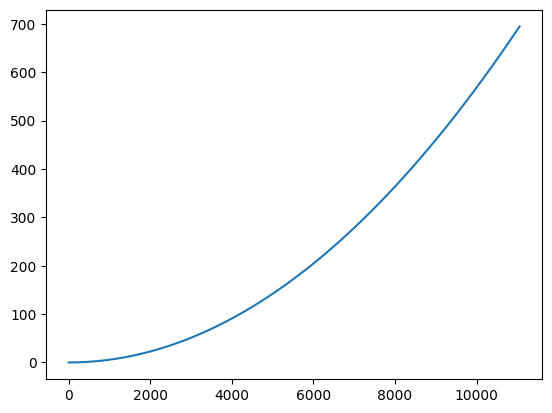

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_27651/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

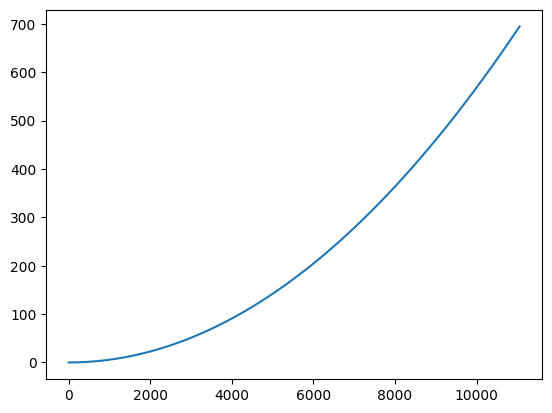

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
    
    glob_force = np.dot(K,np.array(vessel_movement))
    
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6) 
    
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]
#     print(F,'F')
#     print(F)
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T.astype(np.float64)
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        vessel_movement=[-0.1,0,0.20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0],
        coefs=[-2.8871936495153606e-11,
                     -6.420113853324568e-13,
                     -2.6210770865292446e-13,
                     6.589949469337566e-11,
                     3.006123049327487e-11,
                     4.4185824290181994e-11])

In [113]:
d

array([-0.09993548, -0.0009415 ,  0.20035814,  0.02046151,  0.0246436 ,
        0.01610006,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [114]:
f

array([-1.41720833e+05, -2.08311146e-11,  2.82654167e+05,  6.36646291e-11,
       -1.53321800e-12, -1.20508048e-11,  1.39909676e+05, -4.33226986e+02,
       -1.52499893e+03, -2.86461128e+01, -2.46000357e+03,  4.24439657e+02,
        1.27774152e+03, -5.55347597e+02, -2.80501392e+05,  5.46560268e+02,
        1.74410710e+03, -2.25400823e+01,  5.33416001e+02,  9.88574584e+02,
       -6.27775780e+02, -1.36297448e+03, -2.58757760e+01, -1.23588262e+03])

In [115]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    
    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement
    
    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)
#     print('d',d)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,[0.1,
                0.2, 
                 0.3, 
                 0.01, 
                 -0.05, 
                 0.03],
                [-2.8871936495153606e-11,
                     -6.420113853324568e-13,
                     -2.6210770865292446e-13,
                     6.589949469337566e-11,
                     3.006123049327487e-11,
                     4.4185824290181994e-11])

In [117]:
fors

array([[ 2.91946193e-04, -2.25745040e-09,  3.28393494e-07],
       [ 1.84119386e-12,  2.86595758e-11,  1.27109503e-11],
       [ 2.69118061e-12, -1.20027493e-11,  1.05935538e-11],
       [ 5.33084688e-12,  4.38952281e-11, -3.17657012e-12],
       [ 6.80699941e-12,  8.27160741e-13, -1.76928472e-11],
       [ 8.29913915e-12, -9.57225143e-12,  1.34985356e-11],
       [ 6.93489710e-12, -2.01355431e-11,  5.28919131e-11],
       [ 8.95283847e-12,  6.83609019e-11,  1.18318688e-11],
       [ 5.91171556e-12, -5.87525623e-12, -6.85673740e-13],
       [-2.27373675e-13, -1.18168113e-11,  3.95772304e-11],
       [-3.18323146e-12, -2.95793720e-11,  2.25384156e-11],
       [-1.00044417e-11,  5.88941215e-12,  3.12709858e-11],
       [-1.06865627e-11, -7.97298534e-13,  1.07860387e-11],
       [-1.54614099e-11, -4.02050192e-12, -4.91695573e-12],
       [-1.36424205e-11, -4.24900902e-12, -1.98951966e-13],
       [-1.95541361e-11, -5.64966801e-12, -3.06243919e-11],
       [-2.45563569e-11,  1.56168573e-11

### Vessle Simulation

In [118]:
sampleTime = 0.001              # sample time [seconds]
N = 50000                      # number of samples

In [119]:
N*sampleTime

50.0

In [120]:
vehicle=semisub('DPcontrol',1,3,40.0,0,0) 

In [121]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [122]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

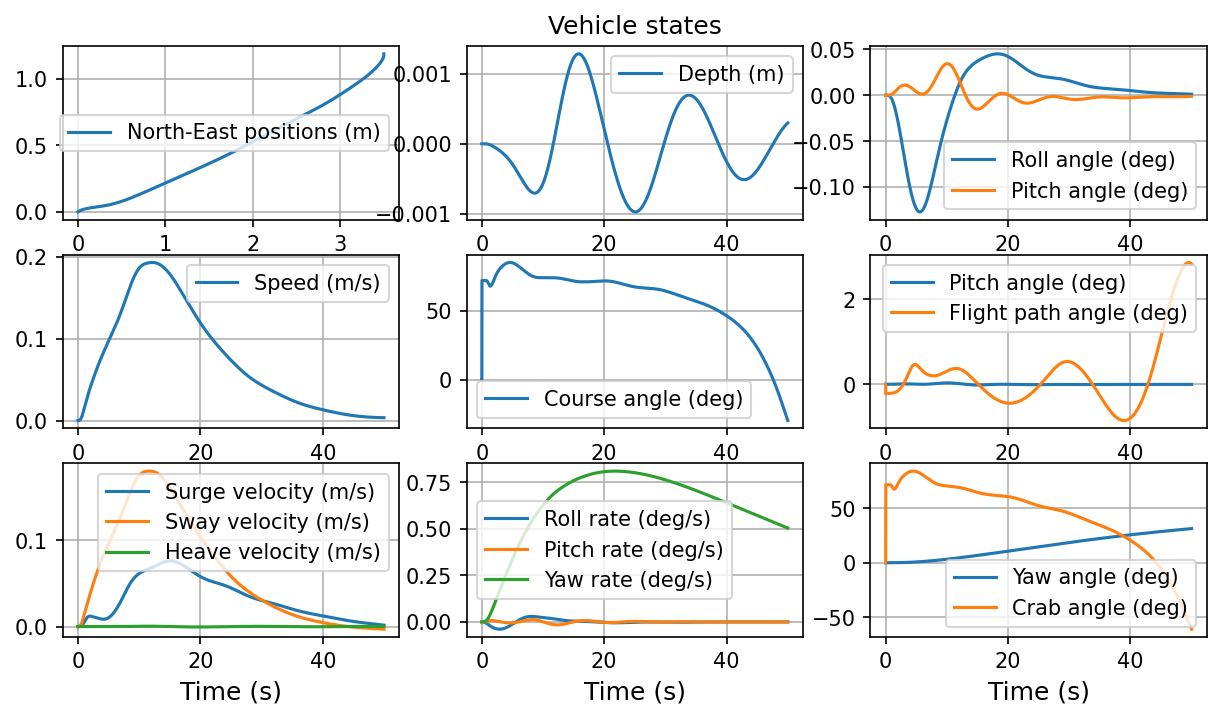

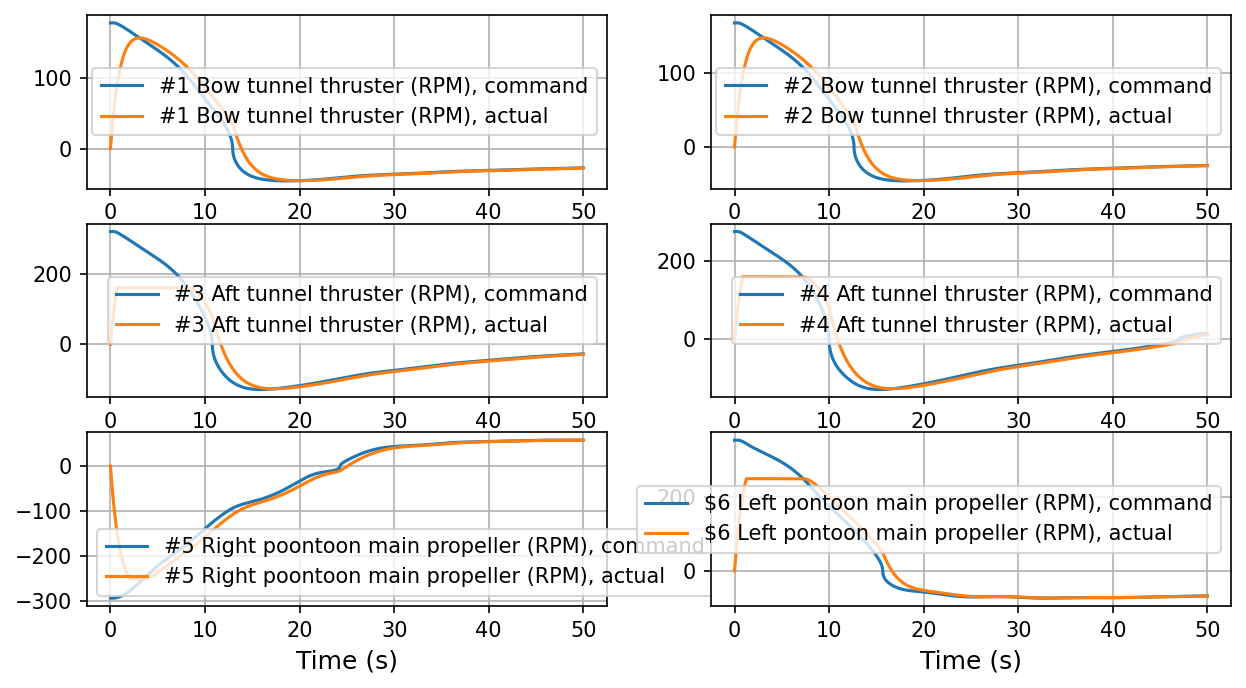

In [123]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [124]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

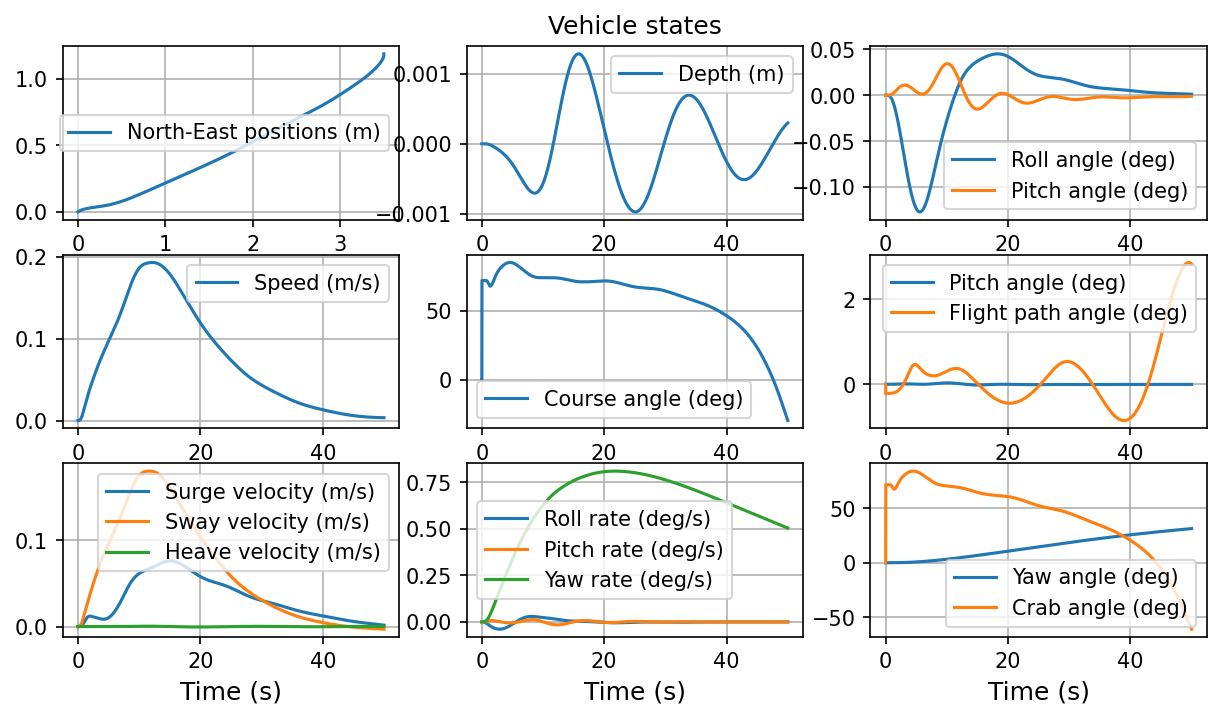

In [125]:
plotVehicleStates(simTime, simData, 3)

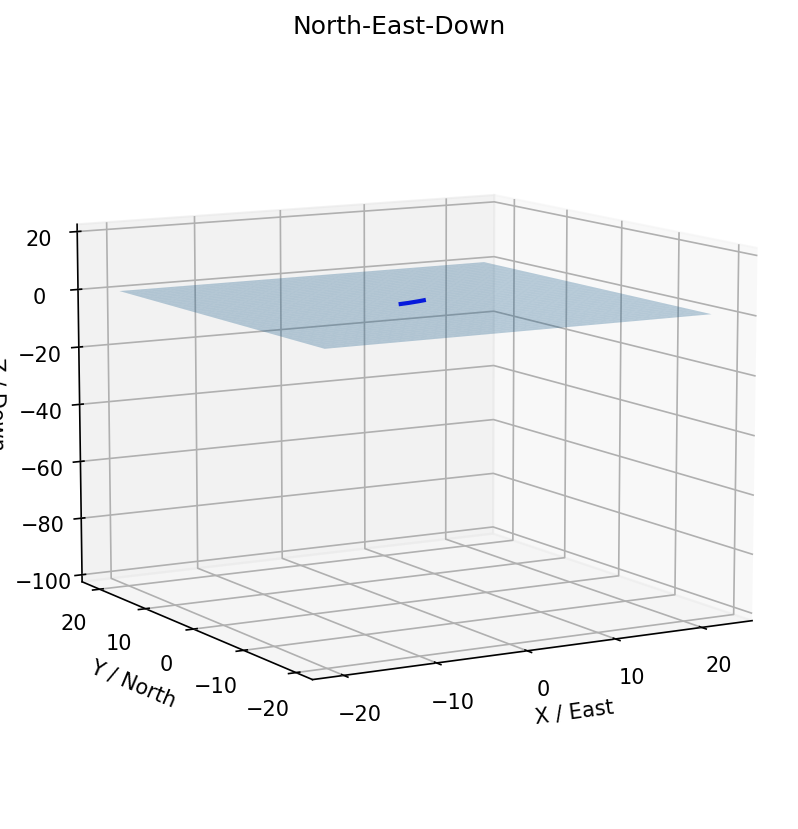

In [126]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

-1.2918830449848429e-08

In [131]:
ssa(simData[:, 4][int(idx)])

2.9831248582468106e-09

In [132]:
ssa(simData[:, 5][int(idx)])

1.3807602172732913e-08

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t=0
        self.v_m=np.array([0,0,0,0,0,0]).astype(np.float64)

In [136]:
def grayscott1d(t, Q, coefs, T): 
#     print(t,T.my_t,t-T.my_t)
#     print(t)
    if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-12:
        return 'error'
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
   
    
    
#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]
    
    
#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])
  
    
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    
    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] =T.v_m[0]-x_ve
    vessel_movement[1] =T.v_m[1]-y_ve
    vessel_movement[2] =T.v_m[2]-z_ve
    vessel_movement[3] =T.v_m[3]-phi_ve
    vessel_movement[4] =T.v_m[4]-theta_ve
    vessel_movement[5] =T.v_m[5]-psi_v
    
 
    T.v_m[0]=x_ve
    T.v_m[1]=y_ve
    T.v_m[2]=z_ve
    T.v_m[3]=phi_ve
    T.v_m[4]=theta_ve
    T.v_m[5]=psi_v
    
    
#     print(vessel_movement )
#     print(T.v_m,"l")
    
    
#     print(vessel_movement)
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
#     vessel_movement0=vessel_movement
#     print(fors.astype(np.float64))
    
    φ,θ,ψ=angle.T

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()
#     print(fors)

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t
#     T.v_m=np.copy(vessel_movement)
  
    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

### Calibration

In [137]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy

import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
sys.path.append('../pipelay_vessel_design_optimisation_using_genetic_algorithms/')

In [139]:
import elitism

In [140]:
BOUNDS_LOW = [-1e-10, -1e-10, -1e-10, -1e-10, -1e-10, -1e-10]
BOUNDS_HIGH = [1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10]

NUM_OF_PARAMS = len(BOUNDS_HIGH)

# Genetic Algorithm constants:
POPULATION_SIZE = 250
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 15 
HALL_OF_FAME_SIZE = 5
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

PENALTY_VALUE = 1e10    # fixed penalty for violating a constraint

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)


# define the hyperparameter attributes individually:
for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])


# create a tuple containing an attribute generator for each param searched:
hyperparameters = ()

for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + (toolbox.__getattribute__("hyperparameter_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 hyperparameters,
                 n=1)


# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [141]:
def dynamics_for_calibration(individual):
    
#     force_schedule_ = individual
    
#     force_schedule=force_schedule_*(1e-12)
#     force_schedule=force_schedule_*1

  
    tspan = (0., 50)
#     print(force_schedule)
    T_ = MyTime()
    try:
        us=solve_ivp(grayscott1d,  tspan, q0, 
#                      t_eval=[i+1 for i in range(tspan[-1])],
#                       atol=1e-2,
                     args=(individual, T_,))
        if us=='error':
            return PENALTY_VALUE,
    except:
        return PENALTY_VALUE, 
    
    x_ve = x0_[-1]-simData[:, 0]
    y_ve = simData[:, 1]
    z_ve = z0_[-1]-simData[:, 2]
    phi_ve = ssa(simData[:, 3])
    theta_ve = ssa(simData[:, 4])
    psi_v = ssa(simData[:, 5])
#     print(x_ve, y_ve, z_ve )
    
    t=us.t
    
    ans_tt=[]
    for i in t:
        idx = find_nearest(np.array(ans_t),  i) 
        ans_tt.append(idx)


#     print(us.y.T[:,49])
#     print(us.y.T[:,2*node_N+49])
#     print(us.y.T[:,4*node_N+49])
#     print()
    ans = (
        np.sqrt(np.sum(( us.y.T[:,49]-x_ve[ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,2*node_N+49]-y_ve[ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,4*node_N+49] - z_ve[ans_tt])**2))
           +
          np.sqrt(np.sum(( us.y.T[:,6*node_N+49]-phi_ve[ans_tt] )**2))+
          np.sqrt(np.sum(( us.y.T[:,8*node_N+49]-theta_ve[ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,10*node_N+49]-psi_v[ans_tt] )**2))
    )
    
#     if ans<A.min_ans:
#         A.min_us=us
#         A.min_ans=ans
#         A.best_indiv=individual
    
    return ans,
    

In [142]:
toolbox.register("evaluate", dynamics_for_calibration)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)


In [143]:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)


    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    
    
    print()
    print("Double check: ")
    
#     force_schedule_ = best
    
#     force_schedule=force_schedule_*1
  
    tspan = (0., 50)
    T_ = MyTime()
    
    us=solve_ivp(grayscott1d,
                 tspan,
                 q0,
#                  atol=1e-2,
#                  t_eval=[i+1 for i in range(tspan[-1])],
                 args=(best, T_,))
    ans_tt=[]
    t=us.t
    
    for i in t:
        idx = find_nearest(np.array(ans_t),  i) 
        ans_tt.append(idx)
        
    print("-- Best Fitness check = ",
          ( np.sqrt(np.sum(( us.y.T[:,49]- (x0_[-1]-simData[:, 0])[ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,2*node_N+49]- simData[:, 1][ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,4*node_N+49] - (z0_[-1]-simData[:, 2])[ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,6*node_N+49]-ssa(simData[:, 3])[ans_tt] )**2))+
          np.sqrt(np.sum(( us.y.T[:,8*node_N+49]-ssa(simData[:, 4])[ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,10*node_N+49]-ssa(simData[:, 5])[ans_tt] )**2)))
#           np.sqrt(np.sum((us.y.T[:,4*node_N+49] - (z0_[-1]-simData[:, 2])[ans_tt])**2))
         )

    
    
    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.savefig("gen.png")
    plt.show()
    return us

gen	nevals	min    	avg   
0  	250   	18.0036	25.661
1  	235   	17.1395	24.2204
2  	233   	17.1395	23.1725
3  	232   	17.1223	22.219 
4  	235   	16.7514	21.7686
5  	235   	16.7514	21.3272
6  	236   	16.7512	21.1511
7  	236   	16.7429	20.9965
8  	236   	16.7429	20.8954
9  	232   	16.7296	20.6041
10 	230   	16.7296	20.3599
11 	228   	16.693 	19.8659
12 	230   	16.6921	19.3919
13 	225   	16.6921	18.9766
14 	235   	16.6795	18.7129
15 	241   	16.6696	18.1898
-- Best Individual =  [2.723630019939446e-11, 9.976188723589116e-12, 1.804550202942943e-11, 4.7028305097320076e-11, 5.679495713505435e-11, -4.361222240850402e-11]
-- Best Fitness =  16.669573816783444

Double check: 
-- Best Fitness check =  16.669573816783444


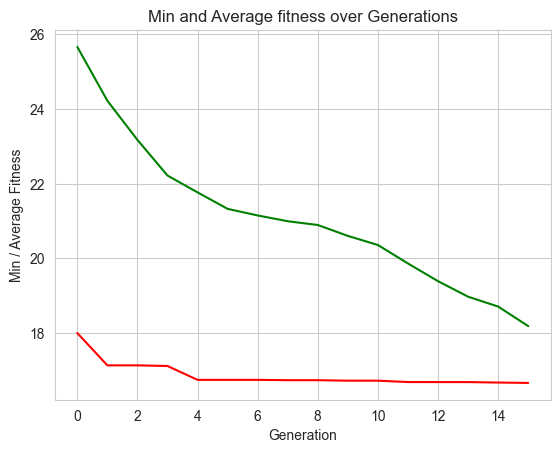

7:27:26.612287


In [144]:
startTime1 = datetime.now()
us=main()
print(datetime.now() - startTime1)

In [145]:
# tspan = (0., 50)
# T_ = MyTime()

In [146]:
# coefs = [-2.8871936495153606e-11,
#                      -6.420113853324568e-13,
#                      -2.6210770865292446e-13,
#                      6.589949469337566e-11,
#                      3.006123049327487e-11,
#                      4.4185824290181994e-11]

In [147]:
# startTime1 = datetime.now()
# us=solve_ivp(grayscott1d,  
#              tspan, 
#              q0,
# #             method='LSODA',
# #              t_eval=[i*sampleTime/10 for i in range(int(tspan[-1]/(sampleTime/10)))],
# #              atol=1e-2,
#              args=(coefs,T_,))
# print(datetime.now() - startTime1)

In [148]:
# key takeaway: it needed FEM model. Space frame element approximation is crude, but seems to work.
# The only parameter to tune is force_schedule

### Results

In [149]:
fin=us

In [150]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.436e-01 ...  4.696e+01  5.000e+01]
        y: [[ 0.000e+00 -1.338e-17 ... -1.729e-08 -1.930e-08]
            [ 2.256e+02  2.256e+02 ...  2.256e+02  2.256e+02]
            ...
            [ 0.000e+00  2.456e-13 ...  1.059e-06  1.053e-06]
            [ 0.000e+00  2.514e-13 ...  1.084e-06  1.078e-06]]
      sol: None
 t_events: None
 y_events: None
     nfev: 146
     njev: 0
      nlu: 0

In [151]:
t=fin.t

In [152]:
fin=fin.y.T

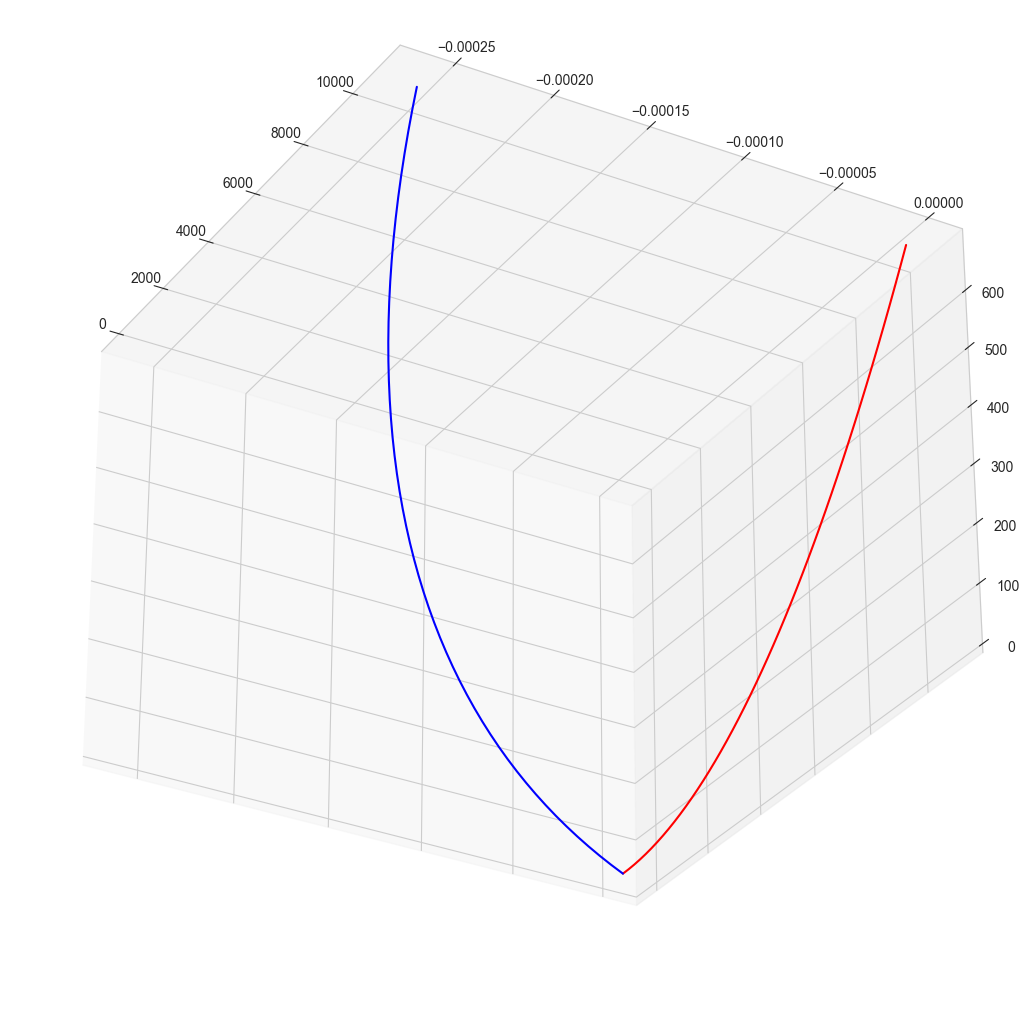

In [153]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [154]:
X,Y,Z

(array([-1.92965913e-08,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
         9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
         1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121496e+03,
         2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
         3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
         4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
         5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
         6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
         7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
         8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
         9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
         9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
         1.08271198e+04,  1.10526848e+04]),
 array([ 3.92641848e-12, -9.75172460e-06, -1

In [155]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [156]:
us=fin.T

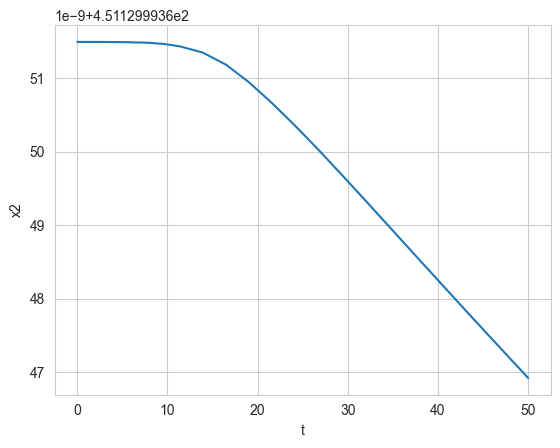

In [157]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

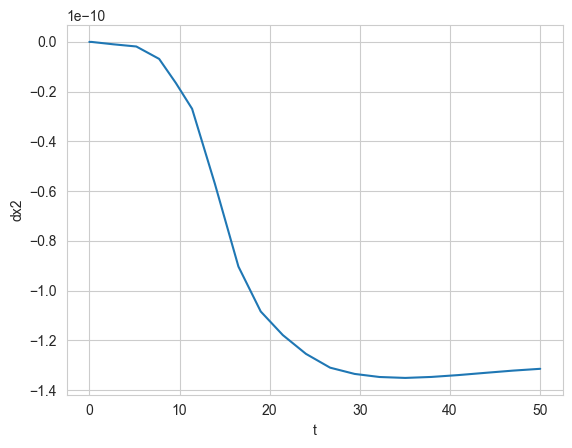

In [158]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

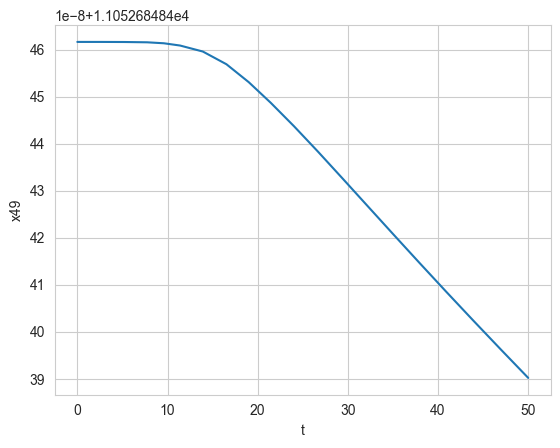

In [159]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

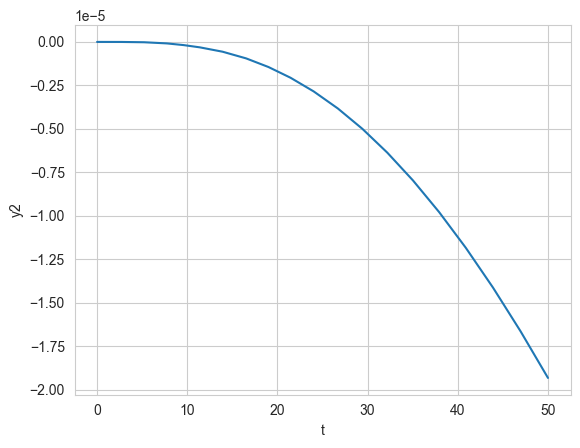

In [160]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

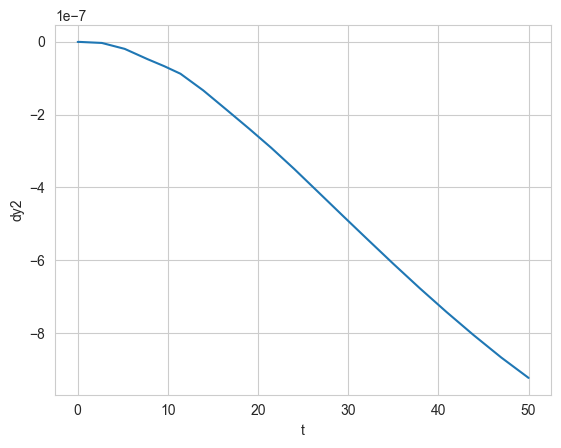

In [161]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

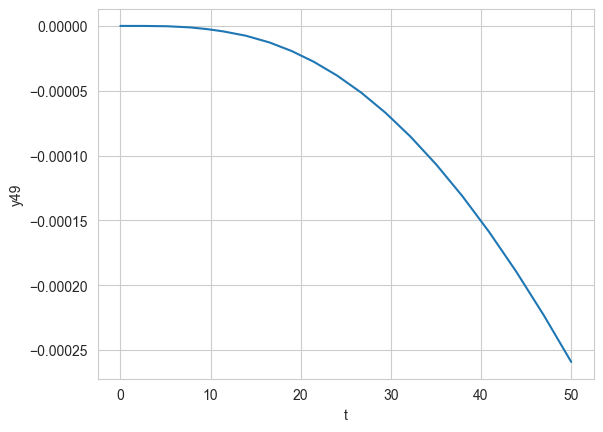

In [162]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

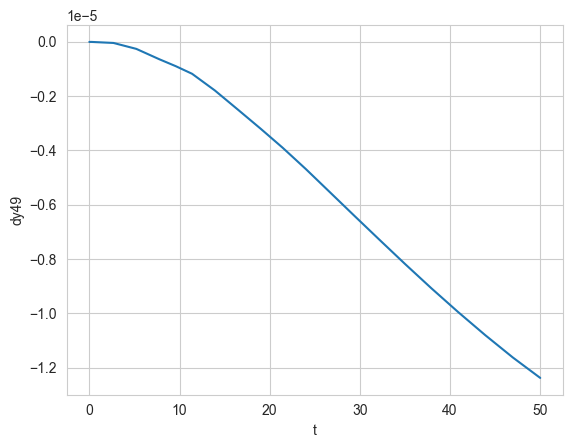

In [163]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

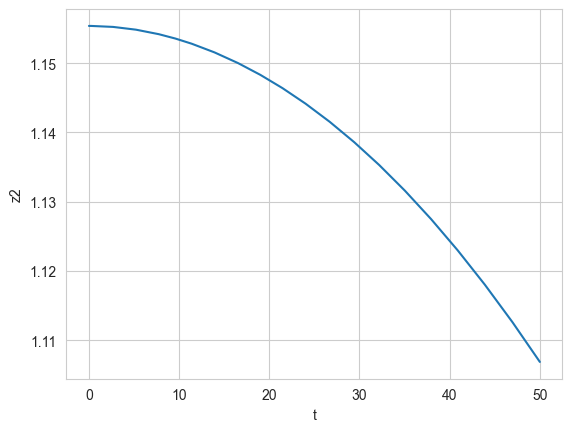

In [164]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

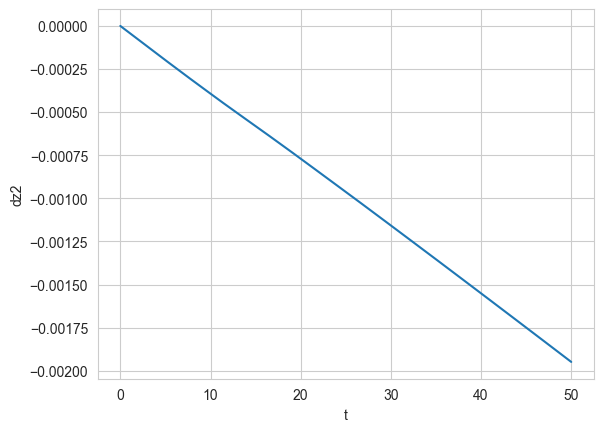

In [165]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

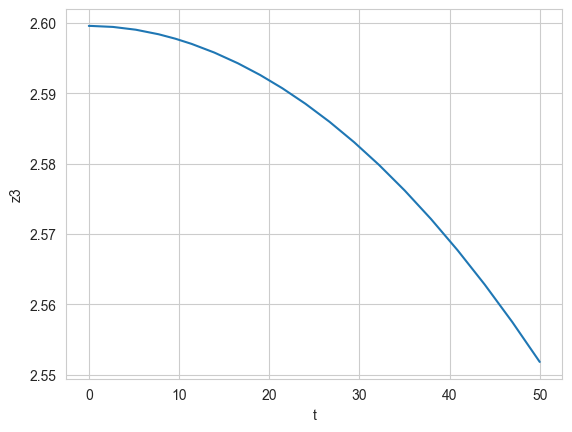

In [166]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

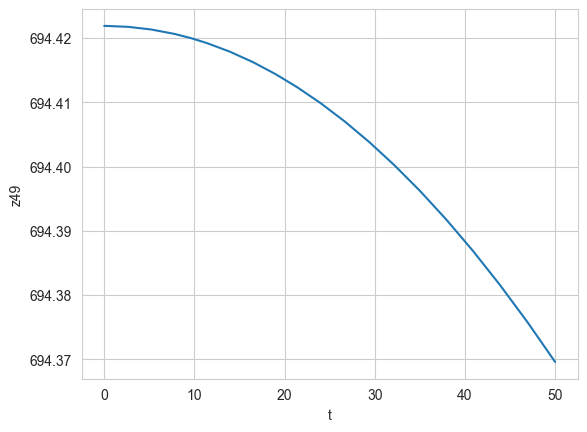

In [167]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

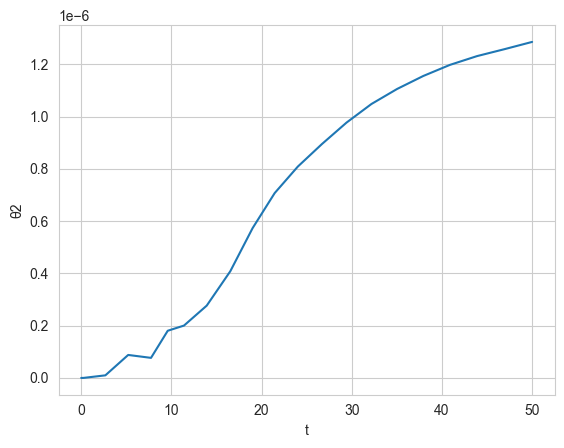

In [168]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

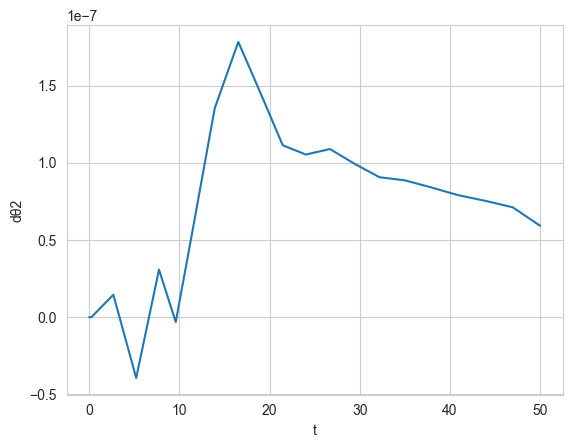

In [169]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

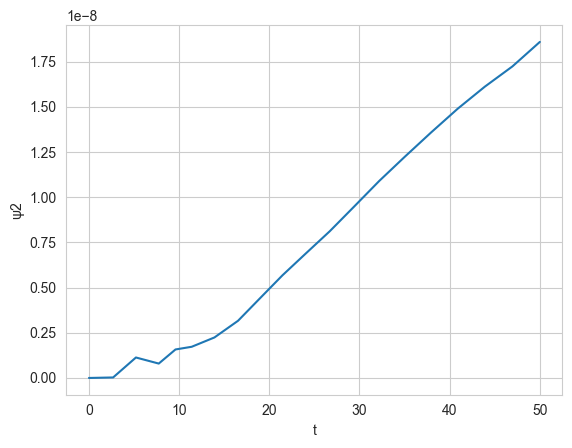

In [170]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

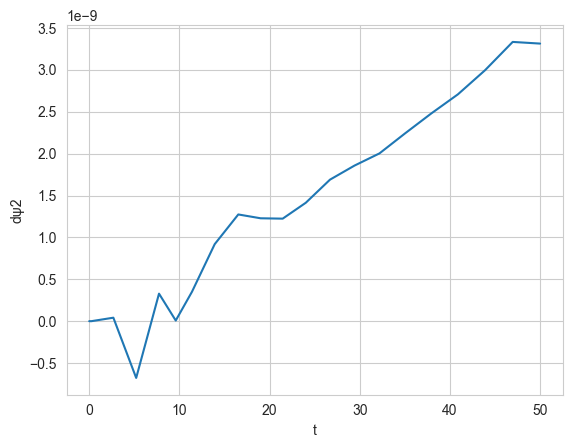

In [171]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()